In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

In [4]:
import seaborn as sns

In [5]:
import gmaps
import gmaps.geojson_geometries

In [6]:
import requests
import json

In [7]:
beer_tax_data = pd.read_csv("resources/brewers_association_data_with_tax_data_2.csv", index_col = 0)
beer_tax_data.head()

,STATE,ZIP Code,NUMBER OF RETURNS,NUMBER OF RETURNS WITH TOTAL INCOME,TOTAL INCOME AMOUNT,NUMBER OF RETURNS WITH SALARIES AND WAGES,SALARIES AND WAGES AMOUNT,Brewery,Address,City
0,AL,35004.0,5210.0,5210.0,290260.0,4550.0,234833.0,NaN,NaN,NaN
1,AL,35005.0,3100.0,3100.0,121690.0,2660.0,98565.0,NaN,NaN,NaN
2,AL,35006.0,1200.0,1200.0,57418.0,1040.0,43707.0,NaN,NaN,NaN
3,AL,35007.0,11940.0,11940.0,697882.0,10180.0,545418.0,siluria brewing company,145 1st ave w,Alabaster
4,AL,35010.0,7910.0,7910.0,384319.0,6700.0,266658.0,NaN,NaN,NaN


In [8]:
# Maybe I need to create a dataframe that aggregates just the tax data by state, then re-merge that with a dataframe
# that groups breweries by state?

state_tax_df = beer_tax_data[["STATE", "ZIP Code", "NUMBER OF RETURNS WITH TOTAL INCOME", "TOTAL INCOME AMOUNT",
                             "NUMBER OF RETURNS WITH SALARIES AND WAGES", "SALARIES AND WAGES AMOUNT"]]
state_brewer_data = beer_tax_data[["STATE", "ZIP Code", "Brewery", "Address", "City"]]

In [9]:
state_tax_df.head()

,STATE,ZIP Code,NUMBER OF RETURNS WITH TOTAL INCOME,TOTAL INCOME AMOUNT,NUMBER OF RETURNS WITH SALARIES AND WAGES,SALARIES AND WAGES AMOUNT
0,AL,35004.0,5210.0,290260.0,4550.0,234833.0
1,AL,35005.0,3100.0,121690.0,2660.0,98565.0
2,AL,35006.0,1200.0,57418.0,1040.0,43707.0
3,AL,35007.0,11940.0,697882.0,10180.0,545418.0
4,AL,35010.0,7910.0,384319.0,6700.0,266658.0


In [10]:
state_tax_df.count()

STATE                                        32745
ZIP Code                                     32735
NUMBER OF RETURNS WITH TOTAL INCOME          32681
TOTAL INCOME AMOUNT                          32681
NUMBER OF RETURNS WITH SALARIES AND WAGES    32681
SALARIES AND WAGES AMOUNT                    32681
dtype: int64

In [11]:
state_tax_no_na_df = state_tax_df.dropna(how = "any")
state_tax_no_na_df.count()

STATE                                        32681
ZIP Code                                     32681
NUMBER OF RETURNS WITH TOTAL INCOME          32681
TOTAL INCOME AMOUNT                          32681
NUMBER OF RETURNS WITH SALARIES AND WAGES    32681
SALARIES AND WAGES AMOUNT                    32681
dtype: int64

In [12]:
state_brewer_data.head()

,STATE,ZIP Code,Brewery,Address,City
0,AL,35004.0,NaN,NaN,NaN
1,AL,35005.0,NaN,NaN,NaN
2,AL,35006.0,NaN,NaN,NaN
3,AL,35007.0,siluria brewing company,145 1st ave w,Alabaster
4,AL,35010.0,NaN,NaN,NaN


In [13]:
state_brewer_data.count()

STATE       32745
ZIP Code    32735
Brewery      7287
Address      7286
City         7287
dtype: int64

In [14]:
state_brewer_no_na_df = state_brewer_data.dropna(subset=["STATE", "Brewery"], how = "any")
state_brewer_no_na_df.count()

STATE       7287
ZIP Code    7277
Brewery     7287
Address     7286
City        7287
dtype: int64

In [15]:
CA_breweries = state_brewer_no_na_df.loc[state_brewer_no_na_df["STATE"] == "CA"]
print(len(CA_breweries))

# CA is our outlier on brewery count

847


In [16]:
brewer_state_groups = state_brewer_no_na_df.groupby(by="STATE")
state_brews = brewer_state_groups.count()

brewers_by_state_df = pd.DataFrame(state_brews)
brewers_by_state_df.reset_index(inplace=True)
brewers_by_state_df.head()

,STATE,ZIP Code,Brewery,Address,City
0,AK,41,41,41,41
1,AL,42,42,41,42
2,AR,39,39,39,39
3,AZ,118,118,118,118
4,CA,845,847,847,847


In [17]:
tax_state_groups = state_tax_no_na_df.groupby(by="STATE")
state_tax_means = tax_state_groups.mean()
tax_by_state_df = pd.DataFrame(state_tax_means)
tax_by_state_df.reset_index(inplace=True)
tax_by_state_df.head()

,STATE,ZIP Code,NUMBER OF RETURNS WITH TOTAL INCOME,TOTAL INCOME AMOUNT,NUMBER OF RETURNS WITH SALARIES AND WAGES,SALARIES AND WAGES AMOUNT
0,AK,99671.184524,2588.988095,183958.494048,2198.571429,127301.089286
1,AL,35952.172414,3469.950739,200435.201970,2918.587849,140634.338259
2,AR,72314.294455,2655.411090,163030.388145,2250.516252,105676.304015
3,AZ,85616.058685,8370.093897,531552.845070,6929.859155,361805.767606
4,CA,93539.706845,11992.881944,978355.903274,9985.466270,667623.095238


In [18]:
state_summary_df = pd.merge(tax_by_state_df, brewers_by_state_df, on = "STATE")
state_summary_df.drop(["ZIP Code_x", "ZIP Code_y", "Address", "City"], axis = 1, inplace = True)
state_summary_df.rename(columns = {
    "NUMBER OF RETURNS WITH TOTAL INCOME": "Mean # Total Income Returns",
    "TOTAL INCOME AMOUNT": "Mean Total Income",
    "NUMBER OF RETURNS WITH SALARIES AND WAGES": "Mean # Returns with Salaries and Wages",
    "SALARIES AND WAGES AMOUNT": "Mean Salaries and Wages",
    "Brewery": "Brewery Count"
}, inplace=True)
state_summary_df.head()

,STATE,Mean # Total Income Returns,Mean Total Income,Mean # Returns with Salaries and Wages,Mean Salaries and Wages,Brewery Count
0,AK,2588.988095,183958.494048,2198.571429,127301.089286,41
1,AL,3469.950739,200435.201970,2918.587849,140634.338259,42
2,AR,2655.411090,163030.388145,2250.516252,105676.304015,39
3,AZ,8370.093897,531552.845070,6929.859155,361805.767606,118
4,CA,11992.881944,978355.903274,9985.466270,667623.095238,847


In [73]:
# model = LinearRegression()
# model.fit(state_summary_df["Mean # Total Income Returns"], state_summary_df["Brewery Count"])

# # Predict y
# x_new = np.linspace(0, 12000,num=100)
# y_new = model.predict(x_new[:,np.newaxis])

# plt.figure()
# ax = plt.axes()
# ax.scatter(state_summary_df["Mean # Total Income Returns"], state_summary_df["Brewery Count"])
# ax.plot(x_new, y_new)

# ax.axis("tight")
# plt.show()

In [74]:
#slope, intercept, r_value, p_value, std_err = stats.linregress(state_summary_df["Mean # Total Income Returns"], state_summary_df["Brewery Count"])

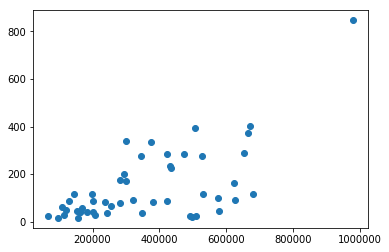

In [21]:
plt.scatter(state_summary_df["Mean Total Income"], state_summary_df["Brewery Count"])

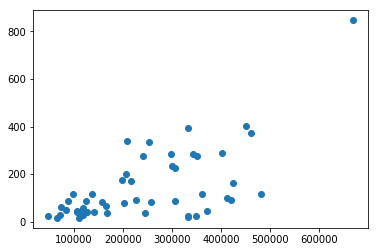

In [22]:
plt.scatter(state_summary_df["Mean Salaries and Wages"], state_summary_df["Brewery Count"])

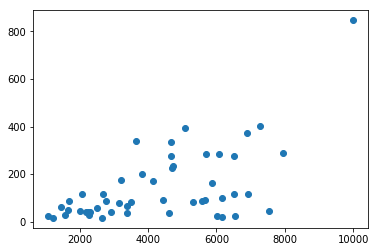

In [23]:
plt.scatter(state_summary_df["Mean # Returns with Salaries and Wages"], state_summary_df["Brewery Count"])

In [ ]:
# Definitely a correlation, but not much of one


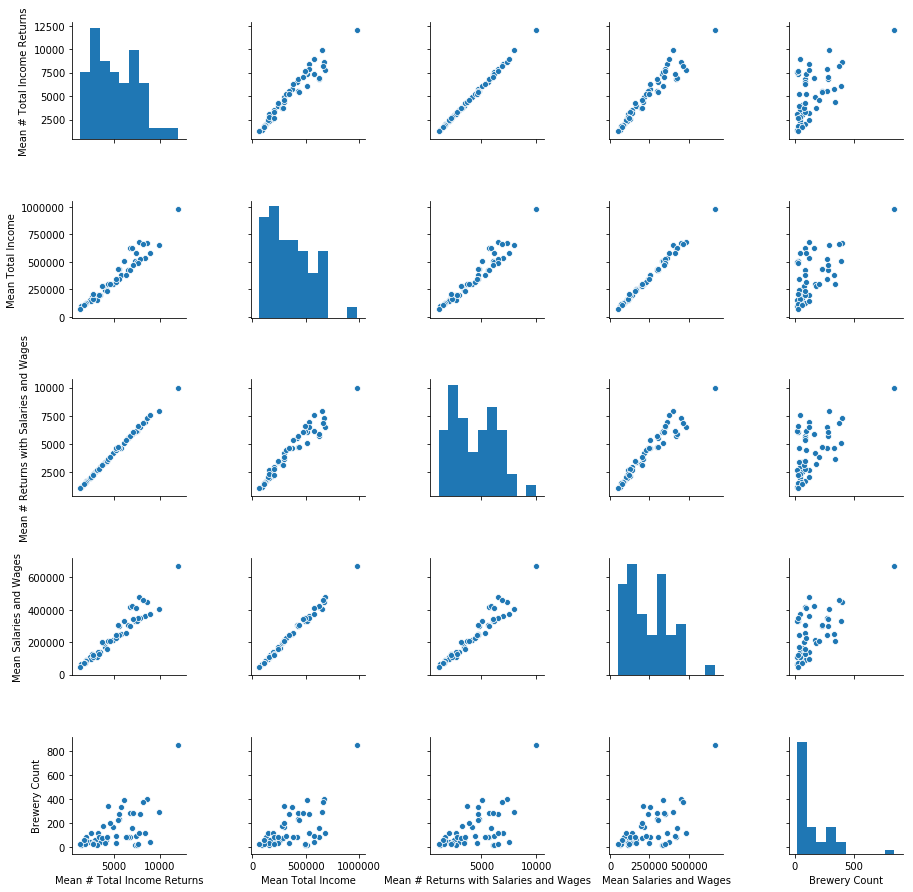

In [24]:
sns.pairplot(state_summary_df)
# Pretty
# The almost perfectly linear relationships between the different tax variables are a nice indicator that we're not working with
# wonky data

In [ ]:
# To Do: run regression analyses
# To Do: plot heat maps

In [25]:
from gconfig import gkey

In [26]:
gmaps.configure(gkey)

In [27]:
fig = gmaps.figure()

In [ ]:
fig

In [29]:
state_brewer_no_na_df.dtypes

STATE        object
ZIP Code    float64
Brewery      object
Address      object
City         object
dtype: object

In [30]:
def trim_fraction(text):
    if ".0" in text:
        return text[:text.rfind(".0")]
    return text

In [31]:
state_brewer_no_na_df["ZIP Code"] = state_brewer_no_na_df["ZIP Code"].astype("str")
state_brewer_no_na_df.dtypes

C:\Users\Stewart\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


STATE       object
ZIP Code    object
Brewery     object
Address     object
City        object
dtype: object

In [32]:
state_brewer_no_na_df["ZIP Code"] = state_brewer_no_na_df["ZIP Code"].apply(trim_fraction)
state_brewer_no_na_df.head()

C:\Users\Stewart\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,STATE,ZIP Code,Brewery,Address,City
3,AL,35007,siluria brewing company,145 1st ave w,Alabaster
25,AL,35055,goat island brewing,1646 a john h cooper drive,Cullman
79,AL,35173,slag heap brewing company,227 main st,Trussville
95,AL,35209,the grocery brewpub,2823 central ave ste 107,Birmingham
106,AL,35222,avondale brewing co,201 41st st s,Birmingham


In [33]:
# Revisit this code, gotta get rid of the decimals from zip codes first
state_brewer_no_na_df["full_address"] = state_brewer_no_na_df["Address"].map(str) + ", " + state_brewer_no_na_df["City"].map(str) + \
    ", " + state_brewer_no_na_df["STATE"].map(str) + "," + state_brewer_no_na_df["ZIP Code"].map(str)

state_brewer_no_na_df.head()

C:\Users\Stewart\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,STATE,ZIP Code,Brewery,Address,City,full_address
3,AL,35007,siluria brewing company,145 1st ave w,Alabaster,"145 1st ave w, Alabaster, AL,35007"
25,AL,35055,goat island brewing,1646 a john h cooper drive,Cullman,"1646 a john h cooper drive, Cullman, AL,35055"
79,AL,35173,slag heap brewing company,227 main st,Trussville,"227 main st, Trussville, AL,35173"
95,AL,35209,the grocery brewpub,2823 central ave ste 107,Birmingham,"2823 central ave ste 107, Birmingham, AL,35209"
106,AL,35222,avondale brewing co,201 41st st s,Birmingham,"201 41st st s, Birmingham, AL,35222"


In [34]:
# Need to combine the strings from 4 columns
# address_list = state_brewer_no_na_df[["Address", "City", "STATE", "ZIP Code"]].tolist()
address_list = state_brewer_no_na_df["full_address"].tolist()
address_list

# Might need to reformat this concatenation for the API call

['145 1st ave w, Alabaster, AL,35007',
 '1646 a john h cooper drive, Cullman, AL,35055',
 '227 main st, Trussville, AL,35173',
 '2823 central ave ste 107, Birmingham, AL,35209',
 '201 41st st s, Birmingham, AL,35222',
 '3201 1st avenue n, Birmingham, AL,35222',
 '4500 5th ave s ste c, Birmingham, AL,35222',
 '2201 2nd ave s ste 102, Birmingham, AL,35233',
 '2616 3rd ave s, Birmingham, AL,35233',
 '114 14th st s, Birmingham, AL,35233',
 '2721 5th ave s, Birmingham, AL,35233',
 '2216 university blvd, Tuscaloosa, AL,35401',
 '607 14th st, Tuscaloosa, AL,35401',
 '1804 4th ave s, Jasper, AL,35501',
 '520 19th st w, Jasper, AL,35501',
 '105 1st ave ne, Decatur, AL,35601',
 '526 e college st, Florence, AL,35630',
 '500 lanier rd, bld 1 - ste a, Madison, AL,35758',
 '208 main st, Madison, AL,35758',
 '289 production ave, Madison, AL,35758',
 '220 holmes ave ne, Huntsville, AL,35801',
 '206 eustis ave se, Huntsville, AL,35801',
 '109 maple ave nw, Huntsville, AL,35801',
 '2620 clinton ave. w, 

In [35]:
base_url =  'https://maps.googleapis.com/maps/api/geocode/json?'
response = requests.get(base_url + "address=" + '526 e college st, Florence, AL,35630' + "&key=" + gkey).json()

In [ ]:
print(json.dumps(response, indent = 4))

In [ ]:
print(response["results"][0]["geometry"]["location"]["lat"])

In [ ]:
# Use geocoding API to extract latitude and longitude from brewery addresses and add them in columns to state_brewer_no_na_df

# lat_list = []
# long_list = []
# error_list = []


# base_url =  'https://maps.googleapis.com/maps/api/geocode/json?'

# for address in address_list: 
#     response = requests.get(base_url + "address=" + address + "&key=" + gkey).json()
    
#     try:
#         lat_list.append(response["results"][0]["geometry"]["location"]["lat"])
#         long_list.append(response["results"][0]["geometry"]["location"]["lng"])
#         print(f"{address} lat/lng successfully extracted")
#     except (KeyError, IndexError, TypeError):
#         print("Address not found, Skipping...")
#         error_list.append(address)
# print("""
# ----------------------------
# Woot
# ----------------------------
# """)
# So this worked, and then it didn't. Maybe I hit my rate limit for the day?

In [36]:
states_geojson = gmaps.geojson_geometries.load_geometry("us-states")
fig = gmaps.figure()
states_layer = gmaps.geojson_layer(states_geojson)
fig.add_layer(states_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [37]:
print(states_geojson["features"][0])

{'type': 'Feature', 'properties': {'GEO_ID': '0400000US04', 'STATE': '04', 'NAME': 'Arizona', 'LSAD': '', 'CENSUSAREA': 113594.084}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-112.538593, 37.000674], [-112.534545, 37.000684], [-112.368946, 37.001125], [-112.35769, 37.001025], [-111.412784, 37.001478], [-111.405869, 37.001481], [-111.405517, 37.001497], [-111.189888, 37.000959], [-110.75069, 37.003197], [-110.495259, 37.003875], [-110.33105, 36.998216], [-110.000677, 36.997968], [-109.381226, 36.999148], [-109.378039, 36.999135], [-109.270097, 36.999266], [-109.268213, 36.999242], [-109.26339, 36.999263], [-109.246917, 36.999346], [-109.233848, 36.999266], [-109.181196, 36.999271], [-109.045223, 36.999084], [-109.045244, 36.969489], [-109.045272, 36.968871], [-109.045407, 36.874998], [-109.045433, 36.874589], [-109.045973, 36.002338], [-109.046011, 35.925896], [-109.046054, 35.92586], [-109.046055, 35.888721], [-109.046024, 35.8798], [-109.046295, 35.616517], [-109.046296, 35.61

In [45]:
print(states_geojson["features"][0]["properties"])

{'GEO_ID': '0400000US04', 'STATE': '04', 'NAME': 'Arizona', 'LSAD': '', 'CENSUSAREA': 113594.084}


In [39]:
print(states_geojson["features"][0]["properties"]["NAME"])

Arizona


In [41]:
print(len(states_geojson["features"]))

52


In [43]:
print(states_geojson["features"][51]["properties"]["NAME"])

Texas


In [46]:
for i in range(0, 51):
    print(states_geojson["features"][i]["properties"]["NAME"])

Arizona
Arkansas
California
Colorado
Connecticut
District of Columbia
Georgia
Hawaii
Illinois
Indiana
Louisiana
Minnesota
Mississippi
Montana
New Mexico
North Dakota
Oklahoma
Pennsylvania
Tennessee
Virginia
Puerto Rico
Delaware
West Virginia
Wisconsin
Wyoming
Alabama
Alaska
Florida
Idaho
Kansas
Maryland
New Jersey
North Carolina
South Carolina
Washington
Vermont
Utah
Iowa
Kentucky
Maine
Massachusetts
Michigan
Missouri
Nebraska
Nevada
New Hampshire
New York
Ohio
Oregon
Rhode Island
South Dakota


In [47]:
state_summary_df["STATE"]
# Cool, I have to append a column of full state names back onto the dataframe for this to work...
# Tutorial for geo_json at https://jupyter-gmaps.readthedocs.io/en/latest/tutorial.html#geojson-layer

0     AK
1     AL
2     AR
3     AZ
4     CA
5     CO
6     CT
7     DE
8     FL
9     GA
10    HI
11    IA
12    ID
13    IL
14    IN
15    KS
16    KY
17    LA
18    MA
19    MD
20    ME
21    MI
22    MN
23    MO
24    MS
25    MT
26    NC
27    ND
28    NE
29    NH
30    NJ
31    NM
32    NV
33    NY
34    OH
35    OK
36    OR
37    PA
38    RI
39    SC
40    SD
41    TN
42    TX
43    UT
44    VA
45    VT
46    WA
47    WI
48    WV
49    WY
Name: STATE, dtype: object

In [51]:
state_names = pd.read_csv("resources/50_us_states_all_data.csv")
state_names = state_names[["state_name", "abbrv"]]
state_names.rename(columns = {
    "abbrv": "STATE"}, inplace= True)
state_names.head()

,state_name,STATE
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [54]:
state_name_summary = pd.merge(state_summary_df, state_names, on="STATE")
state_name_summary.count()

STATE                                     50
Mean # Total Income Returns               50
Mean Total Income                         50
Mean # Returns with Salaries and Wages    50
Mean Salaries and Wages                   50
Brewery Count                             50
state_name                                50
dtype: int64

In [59]:
state_name_summary.head()

,STATE,Mean # Total Income Returns,Mean Total Income,Mean # Returns with Salaries and Wages,Mean Salaries and Wages,Brewery Count,state_name
0,AK,2588.988095,183958.494048,2198.571429,127301.089286,41,Alaska
1,AL,3469.950739,200435.201970,2918.587849,140634.338259,42,Alabama
2,AR,2655.411090,163030.388145,2250.516252,105676.304015,39,Arkansas
3,AZ,8370.093897,531552.845070,6929.859155,361805.767606,118,Arizona
4,CA,11992.881944,978355.903274,9985.466270,667623.095238,847,California


In [58]:
# Create dictionaries of state names and variables to assign colors to geos
mean_total_income_dict = dict(zip(state_name_summary.state_name,\
                                  state_name_summary["Mean Total Income"]))

mean_wage_salary_dict = dict(zip(state_name_summary.state_name, \
                                 state_name_summary["Mean Salaries and Wages"]))

brewer_count_dict = dict(zip(state_name_summary.state_name, \
                             state_name_summary["Brewery Count"]))

In [61]:
from matplotlib.cm import viridis
from matplotlib.colors import to_hex

In [62]:
# Let's start with brewery count

min_brewers = min(brewer_count_dict.values())
max_brewers = max(brewer_count_dict.values())
brewers_range = max_brewers - min_brewers

In [63]:
def calculate_color(brewers_count):
    # Convert the count to a color
    # Convert count to a number between 0 and 1
    normalized_brewers = (brewers_count - min_brewers) / brewers_range
    
    # Invert it so higher counts get a darker color
    inverse_brewers = 1.0 - normalized_brewers
    
    # Transform counts to a matplotlib color
    mpl_color = viridis(inverse_brewers)
    
    # Transform the matplotlib colors to CSS colors to apply to gmaps
    gmaps_color = to_hex(mpl_color, keep_alpha=False)
    
    return gmaps_color

In [64]:
colors = []

for feature in states_geojson["features"]:
    state_name = feature["properties"]["NAME"]
    try:
        brew_count = brewer_count_dict[state_name]
        color = calculate_color(brew_count)
    except KeyError:
        # No count available, return a default color
        color = (0, 0, 0, 0.3)
    colors.append(color)

In [66]:
fig1 = gmaps.figure()
states_layer = gmaps.geojson_layer(states_geojson, \
                                   fill_color = colors, \
                                   stroke_color = colors, \
                                   fill_opacity = 0.8)
fig1.add_layer(states_layer)
fig1

Figure(layout=FigureLayout(height='420px'))

In [67]:
# Let's move on to mean total income

min_total_income = min(mean_total_income_dict.values())
max_total_income = max(mean_total_income_dict.values())
total_income_range = max_total_income - min_total_income

In [70]:
def calculate_income_color(mean_income):
    # Convert the count to a color
    # Convert count to a number between 0 and 1
    normalized_income = (mean_income - min_total_income) / total_income_range
    
    # Invert it so higher counts get a darker color
    inverse_income = 1.0 - normalized_income
    
    # Transform counts to a matplotlib color
    mpl_color = viridis(inverse_income)
    
    # Transform the matplotlib colors to CSS colors to apply to gmaps
    gmaps_color = to_hex(mpl_color, keep_alpha=False)
    
    return gmaps_color

In [71]:
colors = []

for feature in states_geojson["features"]:
    state_name = feature["properties"]["NAME"]
    try:
        mean_income = mean_total_income_dict[state_name]
        color = calculate_income_color(mean_income)
    except KeyError:
        # No count available, return a default color
        color = (0, 0, 0, 0.3)
    colors.append(color)

In [72]:
fig2 = gmaps.figure()
states_layer = gmaps.geojson_layer(states_geojson, \
                                   fill_color = colors, \
                                   stroke_color = colors, \
                                   fill_opacity = 0.8)
fig2.add_layer(states_layer)
fig2

Figure(layout=FigureLayout(height='420px'))